In [1]:
import pickle
import numpy as np
import pandas as pd
import mne
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from scipy.stats import mannwhitneyu
import statsmodels.stats.multitest as multitest

In [2]:
path = Path('../data/asd/raw')
freqs = np.linspace(4, 12, 41)

info = pd.read_csv(path / 'path_file.csv')
info['fn'] = info['fn'].str.replace('и' + chr(774), 'й') # For some reason, filenames encode й as 2 unicode characters
info = info.groupby("fn").filter(lambda x: len(x) == 1)
info.reset_index(drop=True, inplace=True)
typical = np.where(info['target'] == 'typical')[0]
asd = np.where(info['target'] == 'asd')[0]

eegs = {i: mne.io.read_raw_fif(path / fn, verbose=False) for i, fn in info['fn'].items()}
ch_names = eegs[0].ch_names

assert np.all([eegs[i].info['sfreq'] == sfreq for i, sfreq in info['sfreq'].items()])

info

,fn,target,dataset_name,sfreq,age,seconds
0,sedrykyn_sasha_7_og_concat_19.raw.fif,asd,asd,125,7,47.0
1,roma gritchin _5_fon_open_19.raw.fif,asd,asd,125,5,33.0
2,boy5_asd_og_new_19.raw.fif,asd,asd,125,5,50.0
3,viflyancev_4_asd_fon__concat_19.raw.fif,asd,asd,125,4,58.0
4,andrey_matveev3_asd_new_19.raw.fif,asd,asd,125,3,50.0
...,...,...,...,...,...,...
322,artem_sarkis_6_fon_19.raw.fif,typical,typical,125,6,44.0
323,gusarova_9_norm_19.raw.fif,typical,typical,125,9,83.0
324,акулов миша 10 от даши_ог_19.raw.fif,typical,typical,125,10,42.0
325,жавнис_3_19.raw.fif,typical,typical,125,3,386.0


In [3]:
bins = [2, 5, 7, 10]
info["age group"] = np.digitize(info["age"], bins)

In [4]:
age_groups = ["2-4", "5-6", "7-9", "10+"]
freqs = ["2-6 Hz", "4-8 Hz", "8-10 Hz", "10-13 Hz"]

In [5]:
def get_powers(signal, fmin=4, fmax=8, sfreq=125):
    epoch = signal[np.newaxis]
    freqs = np.linspace(fmin, fmax)
    return mne.time_frequency.tfr_array_morlet(
        epoch,
        sfreq=sfreq,
        freqs=freqs,
        output='power',
        verbose=False
    )[0].mean(axis=1)

# def filters(age):
#     if age in range(2, 5):
#         return 4, 12
#     if age in range(5, 7):
#         return 5, 12
#     if age in range(7, 10):
#         return 6, 13
#     return 7, 13

def find_borders(arr):
    return np.where(np.pad(arr, (1, 0))[:-1] < arr), np.where(arr > np.pad(arr, (0, 1))[1:])

def filter_index(index, times, n_seconds, threshold):
    mask = index > threshold
    index_vals = []
    for chan in mask:
        index_val = 0.
        start_ix, end_ix = find_borders(chan)
        for start, end in zip(times[start_ix], times[end_ix]):
            if end - start < .1:
                continue
            index_val += end - start
        index_vals.append(index_val / n_seconds)
    return np.array(index_vals)

In [6]:
def index_1(eeg, fmin, fmax):
    alpha_powers = get_powers(eeg, fmin=fmin, fmax=fmax)
    beta_powers = get_powers(eeg, fmin=13, fmax=30)
    return alpha_powers / beta_powers

def index_2(eeg, fmin, fmax):
    alpha_powers = get_powers(eeg, fmin=fmin, fmax=fmax)
    beta_power = mne.time_frequency.psd_array_welch(eeg, sfreq=125, fmin=13, fmax=30, verbose=False)[0].mean(axis=1)
    return alpha_powers / beta_power[:, None]

In [9]:
beta_powers = [get_powers(eeg[:][0], fmin=13, fmax=30) for eeg in tqdm(eegs.values())]
mean_beta = [mne.time_frequency.psd_array_welch(
                eeg[:][0],
                sfreq=125,
                fmin=13,
                fmax=30,
                verbose=False
            )[0].mean(axis=1) for eeg in tqdm(eegs.values())]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

In [10]:
alpha_powers = {}
alpha_powers["2-6"] = [get_powers(eeg[:][0], 2, 6) for eeg in tqdm(eegs.values())]
alpha_powers["4-8"] = [get_powers(eeg[:][0], 4, 8) for eeg in tqdm(eegs.values())]
alpha_powers["8-10"] = [get_powers(eeg[:][0], 8, 10) for eeg in tqdm(eegs.values())]
alpha_powers["10-13"] = [get_powers(eeg[:][0], 10, 13) for eeg in tqdm(eegs.values())]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

In [11]:
import pickle

with open("powers.pickle", "wb") as file:
    pickle.dump(dict(
        beta_powers=beta_powers,
        mean_beta=mean_beta,
        alpha_powers=alpha_powers
    ), file)

In [7]:
with open("powers.pickle", "rb") as file:
    locals().update(pickle.load(file))

In [8]:
indices_raw_1 = {}
for kind, alpha_power in alpha_powers.items():
    indices_raw_1[kind] = [a / b for a, b in zip(alpha_power, beta_powers)]


In [9]:
indices_raw_2 = {}
for kind, alpha_power in alpha_powers.items():
    indices_raw_2[kind] = [a / m_b[:, None] for a, m_b in zip(alpha_power, mean_beta)]


In [10]:
all_index_1 = pd.concat(
{kind: pd.DataFrame([
        filter_index(idx, eeg.times, seconds, 5)
        for idx, eeg, seconds in zip(indices, eegs.values(), info.seconds.values)
    ], index=info["fn"], columns=ch_names)
    for kind, indices in indices_raw_1.items()
})

all_index_1 = all_index_1.join(info.set_index("fn")[["age group", "target"]])
all_index_1.index.set_names("kind", level=0, inplace=True)
all_index_1.fillna(0., inplace=True)


In [11]:
all_index_1[all_index_1["age group"] != 0].groupby(["age group", "kind", "target"]).mean()

Fp1       Fp2        F7        F3        Fz  \
age group kind  target                                                      
1         2-6   asd      0.848651  0.848771  0.830807  0.858055  0.877040   
                typical  0.694588  0.704514  0.654572  0.723898  0.761742   
          4-8   asd      0.643487  0.652769  0.602908  0.671031  0.712860   
                typical  0.484013  0.505280  0.445620  0.541856  0.576003   
          8-12  asd      0.257493  0.277228  0.251017  0.310053  0.305997   
                typical  0.231001  0.248416  0.197178  0.285777  0.300026   
          10-13 asd      0.122155  0.135626  0.118655  0.152550  0.145321   
                typical  0.119856  0.127357  0.096824  0.152177  0.169164   
2         2-6   asd      0.828693  0.832625  0.784240  0.835063  0.862500   
                typical  0.735470  0.752326  0.695934  0.790087  0.803792   
          4-8   asd      0.608877  0.605440  0.560650  0.629970  0.670553   
                typical  0.521765  0.538331  0.461580  0.591175  0.616143   
          8-12  asd      0.285425  0.260829  0.281607  0.322169  0.322959   
                typical  0.229902  0.246441  0.197891  0.302126  0.300692   
          10-13 asd      0.161290  0.136826  0.149255  0.176996  0.174942   
                typical  0.122180  0.137606  0.108377  0.177232  0.169355   
3         2-6   asd      0.753033  0.761555  0.762005  0.795408  0.795990   
                typical  0.723975  0.707246  0.698658  0.757799  0.781021   
          4-8   asd      0.553769  0.544106  0.531572  0.597093  0.613225   
                typical  0.511477  0.495556  0.473028  0.566875  0.603938   
          8-12  asd      0.254507  0.256130  0.235331  0.286338  0.299343   
                typical  0.252223  0.250601  0.242538  0.306973  0.309944   
          10-13 asd      0.146265  0.147505  0.132826  0.161686  0.166061   
                typical  0.145045  0.149756  0.142771  0.187816  0.183817   
4         2-6   asd      0.593000  0.590701  0.578974  0.609540  0.598824   
                typical  0.635451  0.618988  0.596276  0.628027  0.669565   
          4-8   asd      0.426331  0.406614  0.386914  0.456790  0.451009   
                typical  0.426004  0.423349  0.374834  0.429208  0.495327   
          8-12  asd      0.209649  0.185985  0.168481  0.217241  0.227804   
                typical  0.236872  0.245490  0.193588  0.230230  0.280705   
          10-13 asd      0.117358  0.102213  0.099973  0.128690  0.131591   
                typical  0.146664  0.153686  0.120238  0.141208  0.172968   

                               F4        F8        T3        C3        Cz  \
age group kind  target                                                      
1         2-6   asd      0.858895  0.797023  0.763984  0.868429  0.871991   
                typical  0.722209  0.688360  0.656478  0.759888  0.778062   
          4-8   asd      0.676239  0.582599  0.535630  0.696721  0.725953   
                typical  0.550767  0.493711  0.457550  0.585044  0.617473   
          8-12  asd      0.315754  0.256186  0.203785  0.325928  0.365941   
                typical  0.299968  0.231829  0.231829  0.360342  0.383607   
          10-13 asd      0.150463  0.126140  0.097178  0.155919  0.176011   
                typical  0.165282  0.121070  0.120480  0.215941  0.226299   
2         2-6   asd      0.834187  0.808997  0.784753  0.833246  0.852551   
                typical  0.769440  0.712154  0.684953  0.771507  0.790605   
          4-8   asd      0.605791  0.551445  0.556176  0.634476  0.662953   
                typical  0.557207  0.469908  0.456477  0.569510  0.598645   
          8-12  asd      0.281456  0.253962  0.275529  0.387295  0.364391   
                typical  0.294622  0.209331  0.203672  0.312116  0.359162   
          10-13 asd      0.152952  0.137681  0.152258  0.240230  0.204619   
                typical  0.173663  0.113994  0.113221  0.186595  0.229568   
3         2-6   asd      

In [12]:
all_index_2 = pd.concat(
{kind: pd.DataFrame([
        filter_index(idx, eeg.times, seconds, 770) 
        for idx, eeg, seconds in zip(indices, eegs.values(), info.seconds.values)
    ], index=info["fn"], columns=ch_names)
    for kind, indices in indices_raw_2.items()
})

all_index_2 = all_index_2.join(info.set_index("fn")[["age group", "target"]])
all_index_2.index.set_names("kind", level=0, inplace=True)
all_index_2.fillna(0., inplace=True)

In [13]:
all_index_2[all_index_2["age group"] != 0].groupby(["age group", "kind", "target"]).mean()

Fp1       Fp2        F7        F3        Fz  \
age group kind  target                                                      
1         2-6   asd      0.798742  0.809992  0.764428  0.821444  0.845850   
                typical  0.585178  0.595043  0.517194  0.627814  0.677317   
          4-8   asd      0.501965  0.532597  0.455453  0.554220  0.608129   
                typical  0.323616  0.347382  0.288595  0.418402  0.451414   
          8-12  asd      0.127380  0.146401  0.117407  0.188263  0.173242   
                typical  0.116635  0.125483  0.094306  0.174443  0.191292   
          10-13 asd      0.046053  0.050521  0.045427  0.070162  0.063690   
                typical  0.050361  0.055508  0.036218  0.079034  0.092088   
2         2-6   asd      0.775776  0.785650  0.708070  0.799493  0.838704   
                typical  0.618658  0.645952  0.571180  0.713752  0.726302   
          4-8   asd      0.474936  0.458852  0.425065  0.521348  0.561675   
                typical  0.370108  0.389955  0.288198  0.461670  0.490401   
          8-12  asd      0.161605  0.133158  0.167095  0.198391  0.204043   
                typical  0.110809  0.132593  0.080709  0.174680  0.184127   
          10-13 asd      0.076282  0.058290  0.079255  0.090668  0.090625   
                typical  0.052775  0.064206  0.036648  0.088499  0.092978   
3         2-6   asd      0.660813  0.668031  0.676686  0.723497  0.733158   
                typical  0.602033  0.580551  0.578460  0.670062  0.689042   
          4-8   asd      0.402622  0.385937  0.374503  0.452954  0.478388   
                typical  0.347599  0.328968  0.318486  0.429902  0.465313   
          8-12  asd      0.131802  0.138641  0.116634  0.158931  0.174878   
                typical  0.128555  0.126405  0.125738  0.178741  0.178136   
          10-13 asd      0.068765  0.073339  0.059493  0.081518  0.085950   
                typical  0.067351  0.068384  0.068510  0.098916  0.095929   
4         2-6   asd      0.433742  0.450037  0.414223  0.502009  0.486260   
                typical  0.503932  0.492852  0.455091  0.491432  0.557597   
          4-8   asd      0.268125  0.254081  0.216620  0.318511  0.328883   
                typical  0.271508  0.274625  0.213532  0.287672  0.363958   
          8-12  asd      0.094621  0.083745  0.068777  0.110052  0.120996   
                typical  0.127665  0.137350  0.094626  0.121378  0.161859   
          10-13 asd      0.047508  0.044879  0.036240  0.057978  0.067684   
                typical  0.074800  0.085721  0.059514  0.071463  0.098628   

                               F4        F8        T3        C3        Cz  \
age group kind  target                                                      
1         2-6   asd      0.809511  0.728678  0.660118  0.837142  0.842414   
                typical  0.631285  0.568939  0.523264  0.665606  0.700840   
          4-8   asd      0.550699  0.429148  0.373882  0.589966  0.619648   
                typical  0.421266  0.331156  0.297276  0.459942  0.507527   
          8-12  asd      0.182371  0.132197  0.092606  0.199662  0.230203   
                typical  0.182621  0.116848  0.123796  0.255163  0.269270   
          10-13 asd      0.061955  0.047798  0.035426  0.072092  0.080792   
                typical  0.084820  0.048949  0.054898  0.141195  0.133448   
2         2-6   asd      0.795419  0.741495  0.703546  0.802504  0.822906   
                typical  0.681470  0.599425  0.547902  0.695732  0.712855   
          4-8   asd      0.467577  0.397181  0.385667  0.525823  0.560472   
                typical  0.434807  0.315738  0.280551  0.441280  0.486836   
          8-12  asd      0.153318  0.129539  0.159276  0.269547  0.236606   
                typical  0.183834  0.099005  0.093545  0.197809  0.253704   
          10-13 asd      0.071130  0.063587  0.073557  0.145937  0.114931   
                typical  0.103704  0.046063  0.043901  0.104138  0.150717   
3         2-6   asd      

In [14]:
index_samples_1 = all_index_1[all_index_1["age group"] != 0].groupby(["age group", "kind", "target"]).agg(list)
index_samples_2 = all_index_2[all_index_2["age group"] != 0].groupby(["age group", "kind", "target"]).agg(list)

In [15]:
montage = mne.channels.make_standard_montage('standard_1020')

mne_info = mne.io.meas_info.create_info(montage.ch_names, sfreq=128, ch_types="eeg")
mne.io.RawArray(np.zeros((len(montage.ch_names), 1)), mne_info, copy=None).set_montage(montage)
channels_to_use_ = [ch for ch in mne_info.ch_names if ch in ch_names]
mne_info.pick_channels(channels_to_use_)
_, pos, _, ch_names, _, _, _ = mne.viz.topomap._prepare_topomap_plot(mne_info, 'eeg')
pos = pd.DataFrame(pos, columns=['x', 'y'], index=ch_names)

Creating RawArray with float64 data, n_channels=94, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


In [16]:
def compute_mw(df):
    typical = df.loc[:, :, "typical"]
    asd = df.loc[:, :, "asd"]
    mw_stat, p_values = np.vectorize(mannwhitneyu)(typical, asd)
    n1 = typical.applymap(len)
    n2 = asd.applymap(len)
    return pd.DataFrame(mw_stat / (n1 * n2), columns=df.columns, index=typical.index), \
           pd.DataFrame(p_values, columns=df.columns, index=typical.index)

In [17]:
mw_stats_1, p_values_1 = compute_mw(index_samples_1)
p_values_1_bonferroni = p_values_1 * p_values_1.shape[1]
p_values_1_fdr = p_values_1.apply(lambda row: multitest.fdrcorrection(row)[1])

mw_stats_2, p_values_2 = compute_mw(index_samples_2)
p_values_2_bonferroni = p_values_2 * p_values_2.shape[1]
p_values_2_fdr = p_values_2.apply(lambda row: multitest.fdrcorrection(row)[1])

In [18]:
from matplotlib import colors
import matplotlib.cm

def get_significant(p_values, alpha=.05):
    return (p_values < alpha).T.apply(lambda x: list(x[x].index))

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def plot_topomap(values, ax, highlight):
    mne.viz.utils.plot_sensors(mne_info, show_names=highlight, axes=ax, show=False, pointsize=1)
    ax.scatter(*pos.loc[highlight].values.T, color="black", s=15)
    return mne.viz.plot_topomap(values[pos.index], pos.values,
                                axes=ax, show=False, vmin=0., vmax=1., cmap=cmap)

In [19]:
# cmap = truncate_colormap(matplotlib.cm.bwr, minval=-.75, maxval=.75)
cmap = matplotlib.cm.bwr

In [20]:
def plot(mw_stats, p_values, title=None):
    fig, axes = plt.subplots(4, 4, figsize=(14, 11))
    fig.suptitle(title)

    significant = get_significant(p_values)

    for (key, val), ax in zip(mw_stats.iterrows(), axes.T.ravel()):
        im, _ = plot_topomap(val, ax, significant[key])

    for ax, ag_name in zip(axes[0], age_groups):
        ax.set_title(ag_name, fontsize=24)

    for ax, freq in zip(axes.T[0],freqs):
        ax.text(-.15, 0., freq, size=24,
                verticalalignment='center', rotation=90)

    fig.tight_layout()
    fig.subplots_adjust(right=.8)
    cbar_ax = fig.add_axes([.82, .15, .02, .7])
    fig.colorbar(im, cax=cbar_ax).set_label("Normalized Mann-Whitney U", size=24)
    return fig

In [28]:
%%capture
plot(mw_stats_1, p_values_1)
plt.savefig("../output/mw_stats_1.png")
plot(mw_stats_1, p_values_1_bonferroni)
plt.savefig("../output/mw_stats_1_bonferroni.png")
plot(mw_stats_1, p_values_1_fdr)
plt.savefig("../output/mw_stats_1_fdr.png")

In [29]:
%%capture
plot(mw_stats_2, p_values_2)
plt.savefig("../output/mw_stats_2.png")
plot(mw_stats_2, p_values_2_bonferroni)
plt.savefig("../output/mw_stats_2_bonferroni.png")
plot(mw_stats_2, p_values_2_fdr)
plt.savefig("../output/mw_stats_2_fdr.png")

In [21]:
area_of_interest = [name for name in ch_names if name.startswith("F") or name.startswith("C")]
print(*area_of_interest, sep=", ")

Fp1, Fp2, F7, F3, Fz, F4, F8, C3, Cz, C4


In [22]:
index_1_aoi = index_samples_1[area_of_interest].sum(axis=1).unstack(0)
index_2_aoi = index_samples_2[area_of_interest].sum(axis=1).unstack(0)

In [23]:
means_1 = index_1_aoi.applymap(np.mean)
stds_1 = index_1_aoi.applymap(np.std)
# mean_diffs_1 = means_1.loc[:, :, "asd"] - means_1.loc[:, :, "typical"]
means_2 = index_2_aoi.applymap(np.mean)
stds_2 = index_2_aoi.applymap(np.std)
# mean_diffs_2 = means_2.loc[:, :, "asd"] - means_2.loc[:, :, "typical"]

In [65]:
pd.DataFrame(np.vectorize(lambda mean, std: f"{mean:.3f} ({std:.3f})")(means_1, stds_1), columns=age_groups, index=means_1.index).to_excel("../output/means_1.xlsx")
pd.DataFrame(np.vectorize(lambda mean, std: f"{mean:.3f} ({std:.3f})")(means_2, stds_2), columns=age_groups, index=means_2.index).to_excel("../output/means_2.xlsx")

In [47]:
index_samples_1.applymap(len).loc[:, "2-6", :]["Cz"].unstack()

target,asd,typical
age group,,
1,45,37
2,36,47
3,44,53
4,21,43


In [24]:
mw_stats_1.T.round(3).to_excel("../output/mw_stats_1.xlsx")
p_values_1.T.round(3).to_excel("../output/p_values_1.xlsx")
p_values_1_bonferroni.T.round(3).to_excel("../output/p_values_1_bonferroni.xlsx")
p_values_1_fdr.T.round(3).to_excel("../output/p_values_1_fdr.xlsx")
mean_diffs_1.T.round(3).to_excel("../output/mean_diffs_1.xlsx")

mw_stats_2.T.round(3).to_excel("../output/mw_stats_2.xlsx")
p_values_2.T.round(3).to_excel("../output/p_values_2.xlsx")
p_values_2_bonferroni.T.round(3).to_excel("../output/p_values_2_bonferroni.xlsx")
p_values_2_fdr.T.round(3).to_excel("../output/p_values_2_fdr.xlsx")
mean_diffs_2.T.round(3).to_excel("../output/mean_diffs_2.xlsx")


In [87]:
index_1_aoi_flat = all_index_1.reset_index()
index_1_aoi_flat["Index"] = index_1_aoi_flat[area_of_interest].mean(axis=1)
index_1_aoi_flat = index_1_aoi_flat.loc[index_1_aoi_flat["age group"] != 0, ["kind", "age group", "target", "Index"]]
index_1_aoi_flat["kind"] += " Hz"
index_1_aoi_flat["age group"] = index_1_aoi_flat["age group"].map(dict(zip(range(1, 5), age_groups)))
index_1_aoi_flat["age group"] += " y.o."
index_1_aoi_flat.rename(columns={"kind": "band", "target": "group"}, inplace=True)

index_2_aoi_flat = all_index_2.reset_index()
index_2_aoi_flat["Index"] = index_2_aoi_flat[area_of_interest].mean(axis=1)
index_2_aoi_flat = index_2_aoi_flat.loc[index_2_aoi_flat["age group"] != 0, ["kind", "age group", "target", "Index"]]
index_2_aoi_flat["kind"] += " Hz"
index_2_aoi_flat["age group"] = index_2_aoi_flat["age group"].map(dict(zip(range(1, 5), age_groups)))
index_2_aoi_flat["age group"] += " y.o."
index_2_aoi_flat.rename(columns={"kind": "band", "target": "group"}, inplace=True)

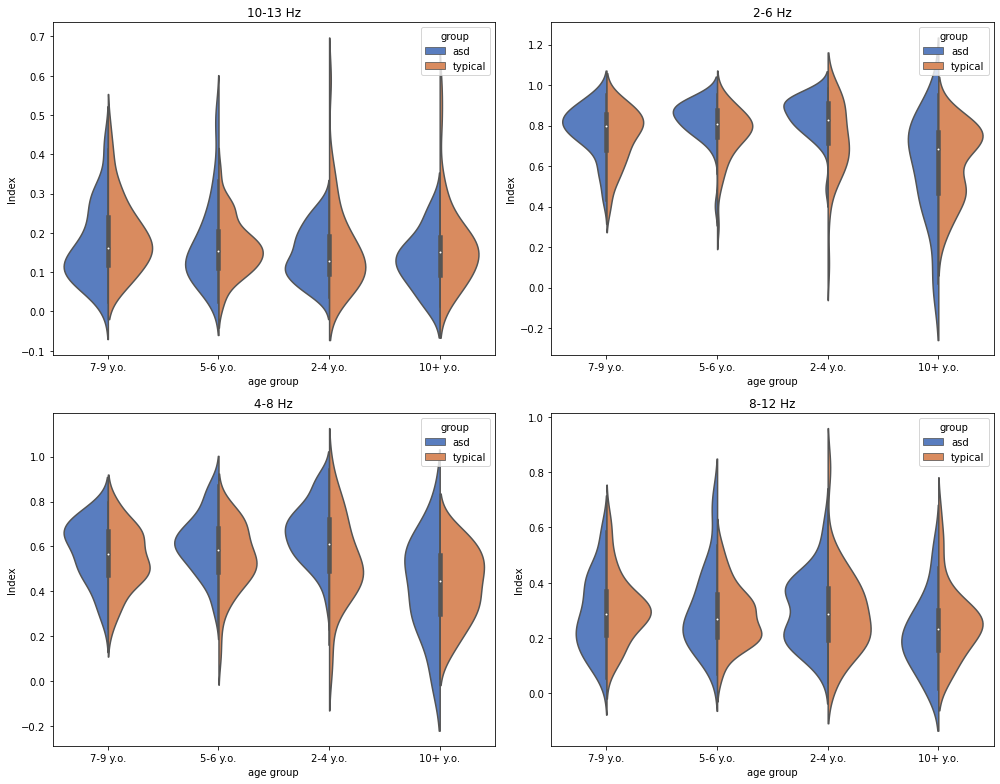

In [88]:
fig, axes = plt.subplots(2, 2, figsize=(14, 11))
for (band, group), ax in zip(index_1_aoi_flat.groupby("band"), axes.flatten()):
    sns.violinplot(x="age group", y="Index", hue="group",
                   data=group, palette="muted", split=True, ax=ax)
    ax.set_title(band)
fig.tight_layout()
plt.savefig("../output/violin_aoi_1.png")

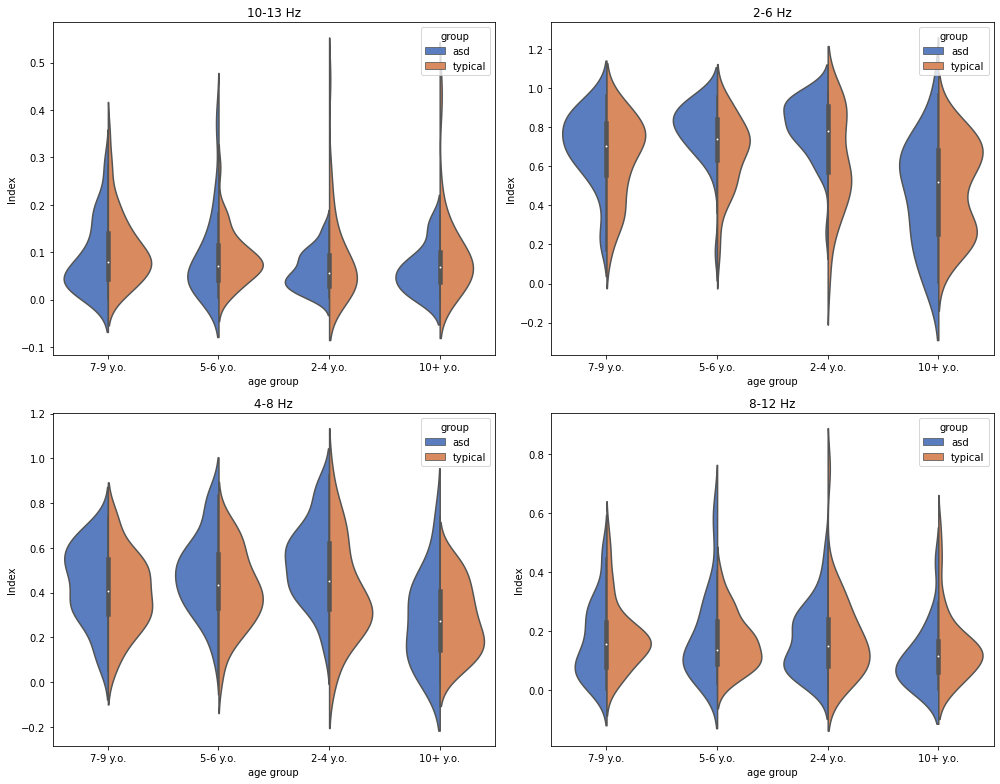

In [89]:
fig, axes = plt.subplots(2, 2, figsize=(14, 11))
for (band, group), ax in zip(index_2_aoi_flat.groupby("band"), axes.flatten()):
    sns.violinplot(x="age group", y="Index", hue="group",
                   data=group, palette="muted", split=True, ax=ax)
    ax.set_title(band)
fig.tight_layout()
plt.savefig("../output/violin_aoi_2.png")